# Procesado de modelos 3D

In [60]:
# Imports
import trimesh
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import pyvista as pv
from PIL import Image
import vtk

### Funciones auxiliares

Función para sacar una imagen 2D dado un objeto en 3D

In [100]:
def take_screenshot(actors, plane, colors = None, textures = None, position = None, window_size = [1024, 768]):
    
    if position is None:
        position = [0.0, 0.0, 0.0]

        if plane.lower() == "xy" or plane.lower() == "yx":
            position[2] = 1000.0
        elif plane.lower() == "yz" or plane.lower() == "zy":
            position[0] = 1000.0
        elif plane.lower() == "xz" or plane.lower() == "zx":
            position[1] = 1000.0 
        else:
            print("ERROR: Wrong plane", plane)
            exit(1)
        

    plotter = pv.Plotter(off_screen = True, window_size = window_size)
    plotter.set_background("white")

    if colors is None:
        colors = [None] * len(actors)

    if textures is None:
        textures = [None] * len(actors)

    for actor, color, tex  in zip(actors, colors, textures):
        _ = plotter.add_mesh(actor, color = color, texture = tex)

    plotter.set_position(position)
    plotter.set_focus([0.0, 0.0, 0.0])
    plotter.enable_parallel_projection()
    plotter.parallel_scale = 200

    return np.array(plotter.screenshot()), plotter

Función para pasar punto 2D a punto 3D

In [91]:
def convert_2d_point_to_3d(pv_mesh, point, plotter):
    
    coordinate = vtk.vtkCoordinate()
    coordinate.SetCoordinateSystemToNormalizedDisplay()

    # the system coordinates is normalized, so 0.5 is the half of the image
    coordinate.SetValue(point[0], point[1])
    world_point = coordinate.GetComputedWorldValue(plotter.renderer)

    start = [world_point[0], world_point[1], 600]
    end = [world_point[0], world_point[1], -600]
    print(start)
    print(end)

    points, _ = pv_mesh.ray_trace(start, end)

    final_point = None

    if len(points) > 0:
        final_point = points[0]

    return final_point

### Obtener puntos clave modelo referencia

Cargamos el modelo de referencia 3D

In [63]:
# Ruta del archivo .obj
obj_file_path = 'H3DS-net/full_head.obj'
texture_file_path = 'H3DS-net/full_head.png'

# Importar la malla desde el archivo .obj
pv_mesh = pv.read(obj_file_path)

# Leer la textura desde el archivo de imagen
texture = pv.read_texture(texture_file_path)

# Llamar a la función take_screenshot
screenshot, plotter = take_screenshot([pv_mesh], plane='xy', textures=[texture])

# Convertir la captura de pantalla (matriz NumPy) a una imagen de Pillow
image = Image.fromarray(np.uint8(screenshot))

# Guardar la imagen en un archivo de imagen
image.save('modelo_referencia.png')

Cargamos la imagen 2D

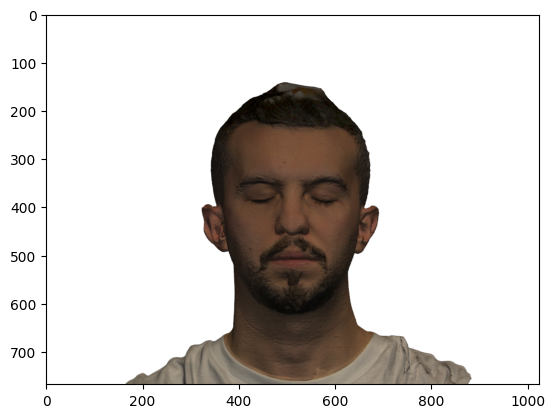

In [64]:
# Especifica el nombre del archivo para lectura de datos
imagen = 'modelo_referencia.png'

# Leer la imagen
img = cv2.imread(imagen)

# Muestra la imagen
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.show()

Calculamos los puntos clave de la cara

I0000 00:00:1702936388.689869   30559 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1702936388.692727   32791 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.0.4-0ubuntu1~22.04.1), renderer: AMD Radeon Vega 8 Graphics (raven, LLVM 15.0.7, DRM 3.49, 6.2.0-32-generic)
W0000 00:00:1702936388.706730   30559 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


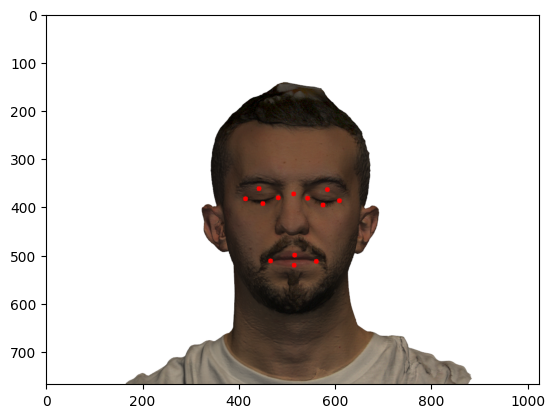

In [65]:
# Crear un objeto FaceLandmarker
base_options = python.BaseOptions(model_asset_path='face_landmarker.task')
VisionRunningMode = mp.tasks.vision.RunningMode
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       running_mode=VisionRunningMode.IMAGE,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# Cargar la imagen
image = mp.Image.create_from_file(imagen)

# Detectar los face landmarks de la imagen
detection_result = detector.detect(image)

# Lista de índices de landmarks para nariz, ojos y boca
landmark_indices = [130, 27, 243, 23, 463, 257, 359, 253, 168, 61, 11, 291, 16]

# Dibujar solo los landmarks específicos en la imagen
annotated_image = image.numpy_view().copy()
for face_landmarks in detection_result.face_landmarks:
    for idx in landmark_indices:
        landmark = face_landmarks[idx]
        h, w, _ = annotated_image.shape
        cx, cy = int(landmark.x * w), int(landmark.y * h)
        cv2.circle(annotated_image, (cx, cy), 5, (255, 0, 0), -1)

# Muestra la imagen con los landmarks seleccionados
plt.imshow(annotated_image)
plt.show()

Guardamos los landmarks elegidos

In [66]:
puntos_ref = []
for face_landmarks in detection_result.face_landmarks:
    for idx in landmark_indices:
        landmark = face_landmarks[idx]
        # Crear un vector con las coordenadas x, y, z
        punto_3d = [landmark.x, landmark.y, landmark.z]
        # Agregar el vector a la lista
        puntos_ref.append(punto_3d)

In [67]:
coordenadas_2d_ref = [(x, y) for x, y, _ in puntos_ref]

coordenadas_3d_ref = []

for point in coordenadas_2d_ref:
    # Convertir cada punto 2D a 3D utilizando la función proporcionada
    converted_point = convert_2d_point_to_3d(pv_mesh, point, plotter)

    # Agregar el punto convertido a la lista
    coordenadas_3d_ref.append(converted_point)

# Invertir el valor de la coordenada y en cada punto
coordenadas_3d_ref = [(x, -y, z) for x, y, z in coordenadas_3d_ref]
    
print("Coordenadas 3D resultantes:", coordenadas_3d_ref)

Coordenadas 3D resultantes: [(-50.535995, 0.12711287, -17.555447), (-36.389015, 11.032248, -6.651868), (-15.461413, 1.2884259, -2.917283), (-32.29154, -5.1018715, -1.7589129), (16.348997, 0.66007376, -3.951173), (37.74045, 10.050893, -6.298018), (50.77203, -1.9906521, -15.938639), (32.82299, -6.5261364, -0.984172), (1.393191, 5.5720925, 19.678505), (-23.518053, -66.90862, -6.0222135), (2.1766026, -60.613464, 0.44600034), (25.888952, -67.48111, -7.8815813), (1.8618902, -71.569534, -5.312934)]


In [68]:
output_path = "modelo_referencia.pp"
with open(output_path, "w") as f:
    f.write("<!DOCTYPE PickedPoints>\n")
    f.write("<PickedPoints>\n")
    i = 0
    for idx in coordenadas_3d:
        x, y, z = idx[0], idx[1], idx[2]
        f.write(
            '<point x="{}" y="{}" z="{}" active="1" name="{}" />\n'.format(
                x, y, z, i
            )
        )
        i += 1
    f.write("</PickedPoints>")

### Obtener matriz de transformación para otro modelo

In [101]:
# Ruta del archivo .obj
obj_file_path = 'HeadSpace/130929144738.obj'
texture_file_path = 'HeadSpace/130929144738.bmp'

# Importar la malla desde el archivo .obj
pv_mesh2 = pv.read(obj_file_path)

# Leer la textura desde el archivo de imagen
texture2 = pv.read_texture(texture_file_path)

# Llamar a la función take_screenshot
screenshot, plotter = take_screenshot([pv_mesh2], plane='xy', textures=[texture2])

# Convertir la captura de pantalla (matriz NumPy) a una imagen de Pillow
image = Image.fromarray(np.uint8(screenshot))

# Guardar la imagen en un archivo de imagen
image.save('modelo_objetivo.png')

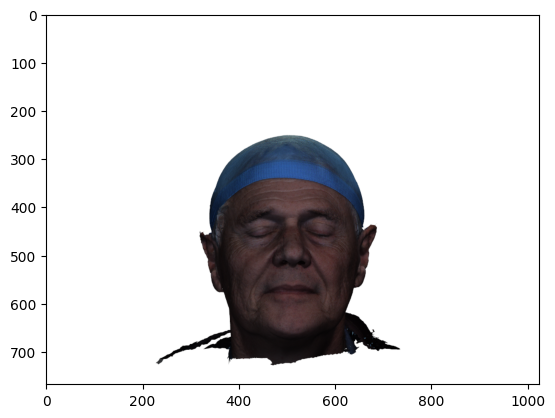

In [102]:
# Especifica el nombre del archivo para lectura de datos
imagen2 = 'modelo_objetivo.png'

# Leer la imagen
img = cv2.imread(imagen2)

# Muestra la imagen
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.show()

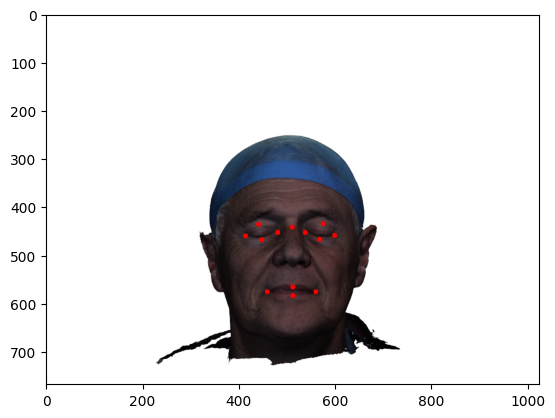

In [103]:
# Cargamos la imagen
image2 = mp.Image.create_from_file(imagen2)

# Detectamos los face landmarks de la imagen
detection_result = detector.detect(image2)

# Dibuja solo los landmarks específicos en la imagen
annotated_image = image2.numpy_view().copy()
for face_landmarks in detection_result.face_landmarks:
    for idx in landmark_indices:
        landmark = face_landmarks[idx]
        h, w, _ = annotated_image.shape
        cx, cy = int(landmark.x * w), int(landmark.y * h)
        cv2.circle(annotated_image, (cx, cy), 5, (255, 0, 0), -1)

# Muestra la imagen con los landmarks seleccionados
plt.imshow(annotated_image)
plt.show()

In [104]:
puntos_obj = []
for face_landmarks in detection_result.face_landmarks:
    for idx in landmark_indices:
        landmark = face_landmarks[idx]
        # Crear un vector con laspuntos_ref coordenadas x, y, z
        punto_3d = [landmark.x, landmark.y, landmark.z]
        # Agregar el vector a la lista
        puntos_obj.append(punto_3d)

In [105]:
coordenadas_2d_obj = [(x, y) for x, y, _ in puntos_obj]
coordenadas_3d_obj = []
print(coordenadas_2d_obj)
for point in coordenadas_2d_obj:
    # Convertir cada punto 2D a 3print(coordenadas_2d_obj)D utilizando la función proporcionada
    converted_point = convert_2d_point_to_3d(pv_mesh2, point, plotter)
    # print(converted_point)
    # Agregar el punto convertido a la lista
    coordenadas_3d_obj.append(converted_point)

# # Filtrar las coordenadas 3D que son None
# coordenadas_3d_obj = [coord for coord in coordenadas_3d_obj if coord is not None]

# Invertir el valor de la coordenada y en cada punto
coordenadas_3d_obj = [(x, -y, z) for x, y, z in coordenadas_3d_obj]
    
print("Coordenadas 3D resultantes:", coordenadas_3d_obj)

[(0.40524086356163025, 0.5993236899375916), (0.43106696009635925, 0.568697988986969), (0.46974173188209534, 0.5910527110099792), (0.43817102909088135, 0.6099076867103577), (0.5254778861999512, 0.5908421874046326), (0.561774492263794, 0.5671634674072266), (0.5859365463256836, 0.5980494618415833), (0.5552811026573181, 0.6086280941963196), (0.4996325969696045, 0.5765835046768188), (0.44911670684814453, 0.7501524686813354), (0.5003344416618347, 0.7377762794494629), (0.5474550127983093, 0.75111323595047), (0.5002276301383972, 0.7607159614562988)]
[-50.53820610046386, 39.72947597503662, 600]
[-50.53820610046386, 39.72947597503662, -600]
[-36.76428794860839, 27.479195594787598, 600]
[-36.76428794860839, 27.479195594787598, -600]
[-16.137742996215817, 36.4210844039917, 600]
[-16.137742996215817, 36.4210844039917, -600]
[-32.975451151529946, 43.963074684143066, 600]
[-32.975451151529946, 43.963074684143066, -600]
[13.58820597330729, 36.33687496185303, 600]
[13.58820597330729, 36.33687496185303,

TypeError: cannot unpack non-iterable NoneType object

In [89]:
output_path = "modelo_objetivo.pp"
with open(output_path, "w") as f:
    f.write("<!DOCTYPE PickedPoints>\n")
    f.write("<PickedPoints>\n")
    i = 0
    for idx in coordenadas_3d_obj:
        x, y, z = idx[0], idx[1], idx[2]
        f.write(
            '<point x="{}" y="{}" z="{}" active="1" name="{}" />\n'.format(
                x, y, z, i
            )
        )
        i += 1
    f.write("</PickedPoints>")

In [ ]:
# Llamar a la función take_screenshot
screenshot, plotter = take_screenshot([pv_mesh, pv_mesh2], plane='xy', textures=[texture, texture2])

# Convertir la captura de pantalla (matriz NumPy) a una imagen de Pillow
image = Image.fromarray(np.uint8(screenshot))

# Guardar la imagen en un archivo de imagen
image.save('modelos_sin_transformar.png')

Registramos de puntos referencia y objetivo

In [14]:
print(puntos_ref)
print(puntos_obj)
print(type(puntos_ref))

v0 = list(zip(*puntos_ref))
v1 = list(zip(*puntos_obj))
matriz_transformacion = trimesh.transformations.affine_matrix_from_points(v0, v1, shear=False,scale=False)

print(matriz_transformacion)

[[0.4095200300216675, 0.3251512050628662, 0.021500004455447197], [0.43089812994003296, 0.29615482687950134, 0.0022127677220851183], [0.4647783637046814, 0.31811749935150146, 0.009916090406477451], [0.43754851818084717, 0.3349906802177429, 0.006324805319309235], [0.5167996287345886, 0.31911954283714294, 0.010954314842820168], [0.5502366423606873, 0.2966178357601166, 0.004109179601073265], [0.5712990760803223, 0.325388640165329, 0.024198833853006363], [0.5438861846923828, 0.3360840082168579, 0.008107014000415802], [0.4911497235298157, 0.3055168688297272, -0.015088346786797047], [0.45136913657188416, 0.4720306992530823, -0.0021084873005747795], [0.49271729588508606, 0.45462465286254883, -0.02999815344810486], [0.5333548188209534, 0.4701245129108429, -0.0008551523787900805], [0.49285340309143066, 0.4778093993663788, -0.02503914013504982], [0.49247878789901733, 0.3807557225227356, -0.0575668141245842], [0.49218690395355225, 0.3629626929759979, -0.05274243280291557]]
[[0.4129512310028076, 0.

In [15]:
points = trimesh.transformations.transform_points(puntos_ref, matriz_transformacion, translate=True)
for i in range(len(points)):
    print(points[i][0] - puntos_obj[i][0], points[i][1] - puntos_obj[i][1], points[i][2] - puntos_obj[i][2])

0.04304641296782574 0.01848079302517258 -0.01382772332467986
0.03132615996949217 0.03753094230034226 -0.005603696552302001
0.01186137196049808 0.025636448735221473 -0.009402537440345898
0.02735195669145024 0.016627487139014685 -0.006412990951514895
-0.012071630971422387 0.0259480284444073 -0.011962040169784395
-0.028912234877354392 0.03820946678598447 -0.009739840580374443
-0.03706366517849924 0.02047612649305619 -0.019151544781663143
-0.023403127357046638 0.0183553557459461 -0.010959958836848166
-0.0026146302480173356 0.03195009176825303 0.0008627097011673444
0.03181864101488863 -0.05298895715356089 -0.0005622773412491937
-0.0032402900810721835 -0.061895763707932705 0.017948394865511454
-0.027845177490682493 -0.05775492397579929 -0.005314942530130389
-0.0017265181069954227 -0.07051415374923775 0.018235589604744244
-0.004460009369868567 0.0017878494836158776 0.02951607092408183
-0.00406725892319626 0.008151208665517384 0.026374787413387474


In [16]:
# Aplicar la matriz de transformación al modelo que queremos transformar
mesh3 = trimesh.load(obj2, process=False)
mesh3.apply_transform(matriz_transformacion)

<trimesh.Trimesh(vertices.shape=(136250, 3), faces.shape=(253348, 3), name=`130929144738.obj`)>

In [17]:
# Crear una escena
escena = trimesh.Scene()

# Añadimos los dos modelos (el referencia y el objetivo transformado)
escena.add_geometry(mesh3)
escena.add_geometry(mesh)

# Guardamos la imagen
png = escena.save_image(visible=False)
with open('escena_transformada.png', "wb") as f:
    f.write(png)
    f.close()

### Problemas

- No coge bien la traslación en el eje Z (la profundidad). Creo que puede ser por la detección de puntos en la imagen 2D